In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

In [2]:
# Load the dataset
file_path = 'mosquito_dataset_2017_2024.csv'
df = pd.read_csv(file_path, parse_dates=['Date'], index_col='Date')

In [3]:
# --- Null Value Checking ---
print("\nChecking for null values...")
if df.isnull().sum().any():
    print("Null values found. Applying forward fill.")
    df.fillna(method='ffill', inplace=True)
else:
    print("No null values found.")


Checking for null values...
No null values found.



Plotting the target variable 'PremiseIndex' over time...


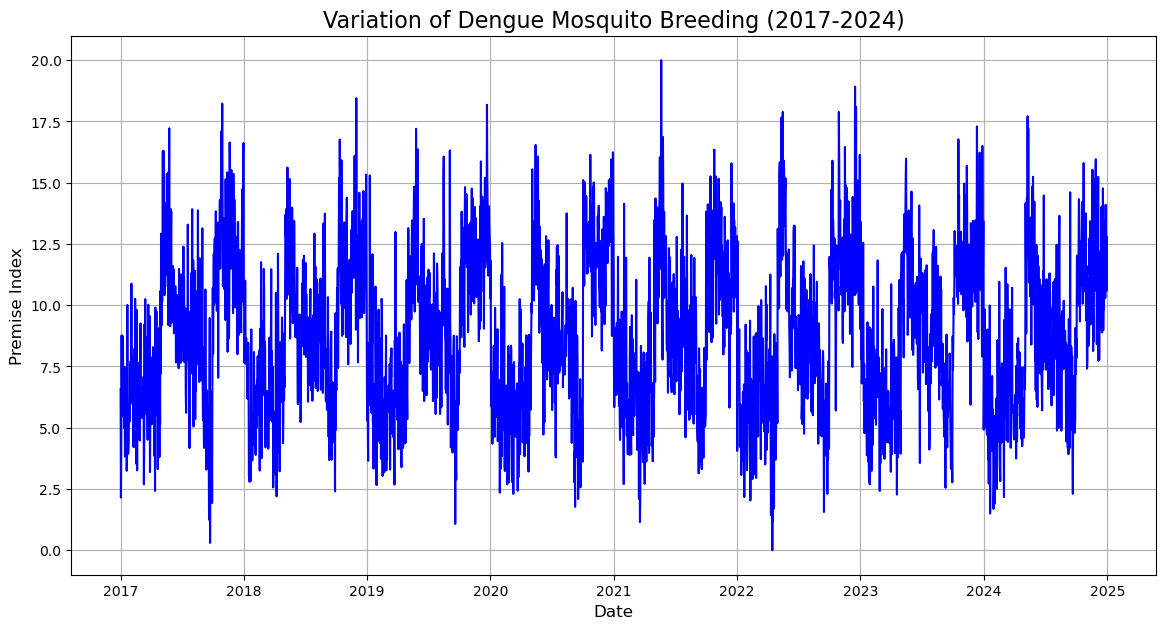

In [4]:
# --- Visualize the Target Variable ---
print("\nPlotting the target variable 'PremiseIndex' over time...")
plt.figure(figsize=(14, 7))
plt.plot(df.index, df['PremiseIndex'], linestyle='-', color='b')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Premise Index', fontsize=12)
plt.title('Variation of Dengue Mosquito Breeding (2017-2024)', fontsize=16)
plt.grid(True)
plt.show()

In [5]:
# converts the 'Wet'/'Dry' season into a numerical format (0 or 1)
df_encoded = pd.get_dummies(df, columns=['Season'], drop_first=True)
# We will now use 'PremiseIndex' and 'Season_Wet' as our features
features = ['PremiseIndex', 'Season_Wet']
data = df_encoded[features]

print("\nDataframe after encoding 'Season' column:")
print(data.head())


Dataframe after encoding 'Season' column:
            PremiseIndex  Season_Wet
Date                                
2017-01-01          6.57        True
2017-01-02          2.15        True
2017-01-03          4.20        True
2017-01-04          8.77        True
2017-01-05          5.60        True


In [6]:
# Split data chronologically
split_date = '2023-01-01'
train_df = data[data.index < split_date]
test_df = data[data.index >= split_date]

print(f"\nTraining data runs from {train_df.index.min().date()} to {train_df.index.max().date()}")
print(f"Test data runs from {test_df.index.min().date()} to {test_df.index.max().date()}")

# Scale the features
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_df)
test_scaled = scaler.transform(test_df)

print("\n✅ Multi-feature data scaled successfully.")


Training data runs from 2017-01-01 to 2022-12-31
Test data runs from 2023-01-01 to 2024-12-31

✅ Multi-feature data scaled successfully.


In [7]:
def create_multivariate_sequences(data, sequence_length):
    """Creates sequences for multivariate data."""
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        # The target 'y' is the 'PremiseIndex' of the next time step
        y.append(data[i + sequence_length, 0]) # Col 0 is 'PremiseIndex'
    return np.array(X), np.array(y)

sequence_length = 60
X_train, y_train = create_multivariate_sequences(train_scaled, sequence_length)
X_test, y_test = create_multivariate_sequences(test_scaled, sequence_length)

# The number of features is the last dimension of X_train
n_features = X_train.shape[2]
print(f"\nUsing a sequence length of {sequence_length} days with {n_features} features.")
print(f"Shape of X_train: {X_train.shape}")


Using a sequence length of 60 days with 2 features.
Shape of X_train: (2131, 60, 2)


In [20]:
# --- LSTM Model ---

In [8]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, n_features)))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(LSTM(units=50))
model_LSTM.add(Dropout(0.2))
model_LSTM.add(Dense(units=1))

model_LSTM.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- LSTM Model Summary ---")
model_LSTM.summary()

print("\nTraining the LSTM model...")
history_LSTM = model_LSTM.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
print("✅ LSTM Model training complete.")

C:\Users\KavinduRajapaksha\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



--- LSTM Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 60, 50)              │          10,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,851 (120.51 KB)

 Trainable params: 30,851 (120.51 KB)

 Non-trainable params: 0 (0.00 B)


Training the LSTM model...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0307 - val_loss: 0.0142
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0164 - val_loss: 0.0133
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 0.0159 - val_loss: 0.0127
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0150 - val_loss: 0.0133
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0150 - val_loss: 0.0125
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 0.0148 - val_loss: 0.0121
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0153 - val_loss: 0.0128
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - loss: 0.0144 - val_loss: 0.0120
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0144 - val_loss: 0.0126
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0140 - val_loss: 0.0121
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 55ms/step - loss: 0.0139 - val_loss: 0.0119
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━

In [ ]:
# --- GRU Model ---

In [9]:
model_GRU = Sequential()
model_GRU.add(GRU(units=50, return_sequences=True, input_shape=(sequence_length, n_features)))
model_GRU.add(Dropout(0.2))
model_GRU.add(GRU(units=50))
model_GRU.add(Dropout(0.2))
model_GRU.add(Dense(units=1))

model_GRU.compile(optimizer='adam', loss='mean_squared_error')
print("\n--- GRU Model Summary ---")
model_GRU.summary()

print("\nTraining the GRU model...")
history_GRU = model_GRU.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test), verbose=1)
print("✅ GRU Model training complete.")


--- GRU Model Summary ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 60, 50)              │           8,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 50)                  │          15,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,451 (91.61 KB)

 Trainable params: 23,451 (91.61 KB)

 Non-trainable params: 0 (0.00 B)


Training the GRU model...
Epoch 1/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 0.0373 - val_loss: 0.0125
Epoch 2/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - loss: 0.0158 - val_loss: 0.0121
Epoch 3/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 0.0154 - val_loss: 0.0129
Epoch 4/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.0151 - val_loss: 0.0120
Epoch 5/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.0150 - val_loss: 0.0119
Epoch 6/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 0.0146 - val_loss: 0.0122
Epoch 7/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 0.0151 - val_loss: 0.0135
Epoch 8/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - loss: 0.0145 - val_loss: 0.0118
Epoch 9/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0148 - val_loss: 0.0120
Epoch 10/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.0142 - val_loss: 0.0119
Epoch 11/50
67/67 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0141 - val_loss: 0.0122
Epoch 12/50
67/67 ━━━━━━━━━━━━━━━━━

In [10]:
# Make predictions
predictions_LSTM_scaled = model_LSTM.predict(X_test)
predictions_GRU_scaled = model_GRU.predict(X_test)

# To inverse transform, we need to create an array with the same shape as the scaler expects
dummy_array_lstm = np.zeros((len(predictions_LSTM_scaled), n_features))
dummy_array_lstm[:, 0] = predictions_LSTM_scaled.ravel()
predictions_LSTM = scaler.inverse_transform(dummy_array_lstm)[:, 0]

dummy_array_gru = np.zeros((len(predictions_GRU_scaled), n_features))
dummy_array_gru[:, 0] = predictions_GRU_scaled.ravel()
predictions_GRU = scaler.inverse_transform(dummy_array_gru)[:, 0]

# Get actual values
y_test_actual = test_df['PremiseIndex'].iloc[sequence_length:].values

# Calculate RMSE
rmse_LSTM = np.sqrt(mean_squared_error(y_test_actual, predictions_LSTM))
rmse_GRU = np.sqrt(mean_squared_error(y_test_actual, predictions_GRU))

print("\n--- Model Evaluation ---")
print(f"LSTM Model Test RMSE: {rmse_LSTM:.4f}")
print(f"GRU Model Test RMSE: {rmse_GRU:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step

--- Model Evaluation ---
LSTM Model Test RMSE: 2.1614
GRU Model Test RMSE: 2.1973


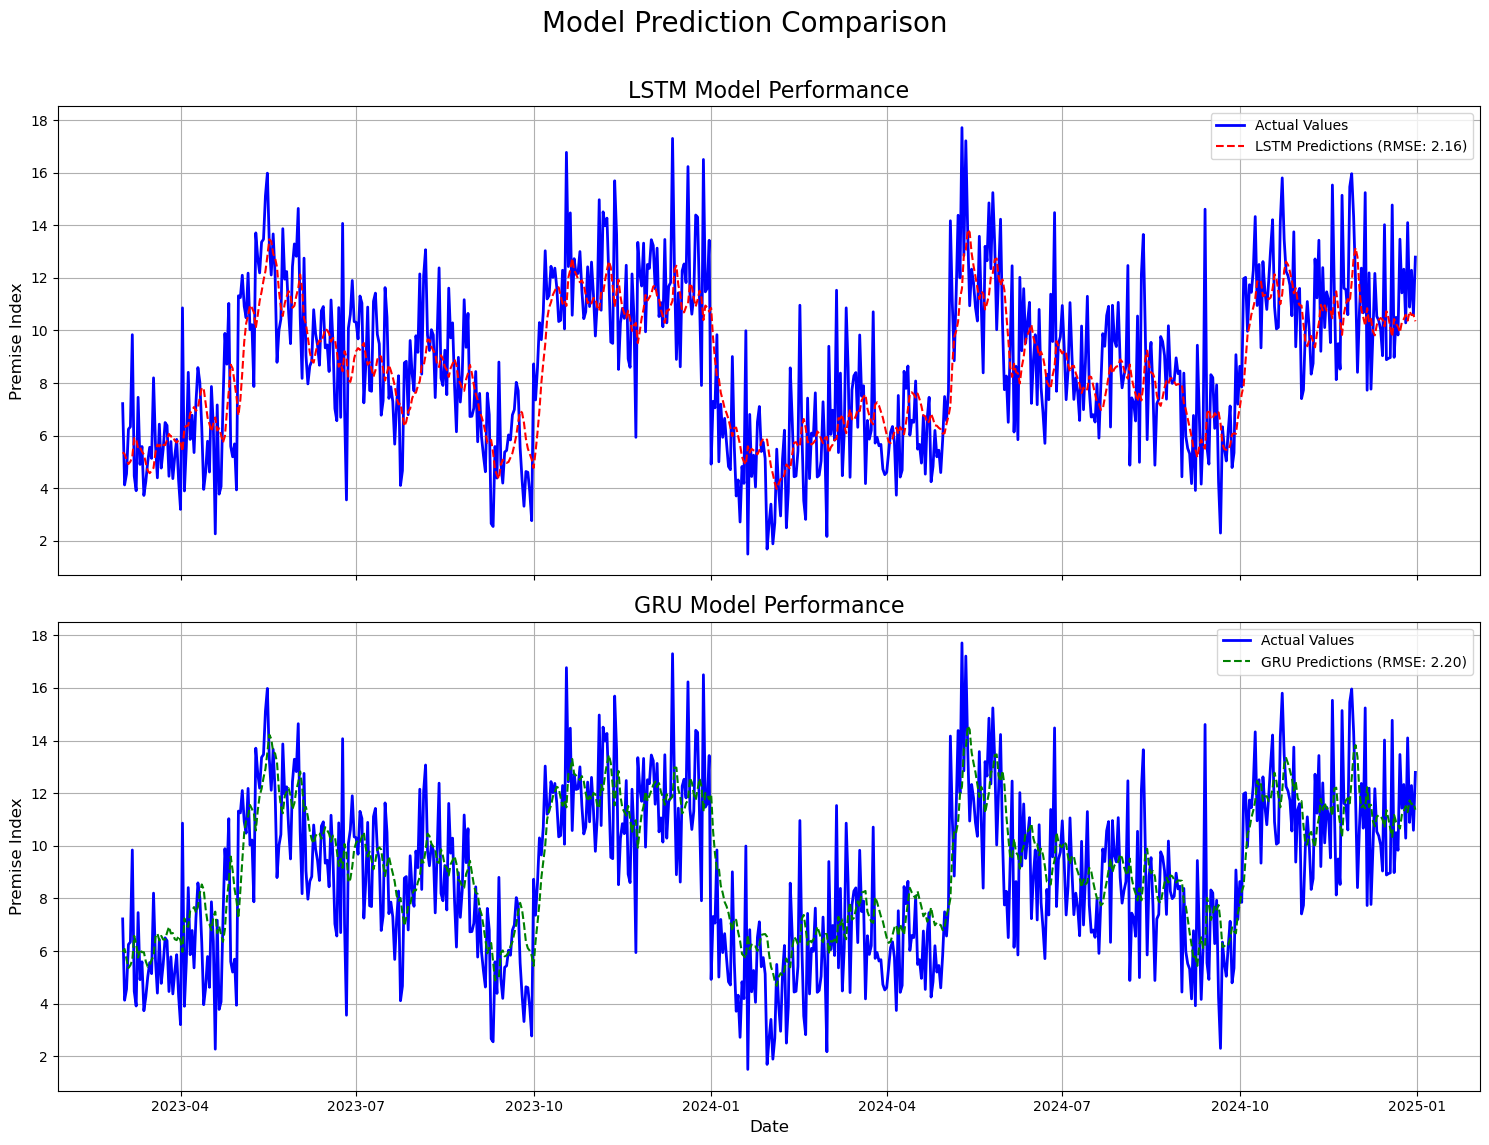

In [11]:
# Create a DataFrame for plotting
plot_df = test_df.iloc[sequence_length:].copy()
plot_df['Actual'] = y_test_actual
plot_df['Predicted_LSTM'] = predictions_LSTM
plot_df['Predicted_GRU'] = predictions_GRU

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Model Prediction Comparison', fontsize=20)

# Plot 1: LSTM Predictions
ax1.plot(plot_df.index, plot_df['Actual'], label='Actual Values', color='blue', linewidth=2)
ax1.plot(plot_df.index, plot_df['Predicted_LSTM'], label=f'LSTM Predictions (RMSE: {rmse_LSTM:.2f})', color='red', linestyle='--')
ax1.set_title('LSTM Model Performance', fontsize=16)
ax1.set_ylabel('Premise Index', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot 2: GRU Predictions
ax2.plot(plot_df.index, plot_df['Actual'], label='Actual Values', color='blue', linewidth=2)
ax2.plot(plot_df.index, plot_df['Predicted_GRU'], label=f'GRU Predictions (RMSE: {rmse_GRU:.2f})', color='green', linestyle='--')
ax2.set_title('GRU Model Performance', fontsize=16)
ax2.set_xlabel('Date', fontsize=12)
ax2.set_ylabel('Premise Index', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.97]) # Adjust layout to make room for suptitle
plt.show()

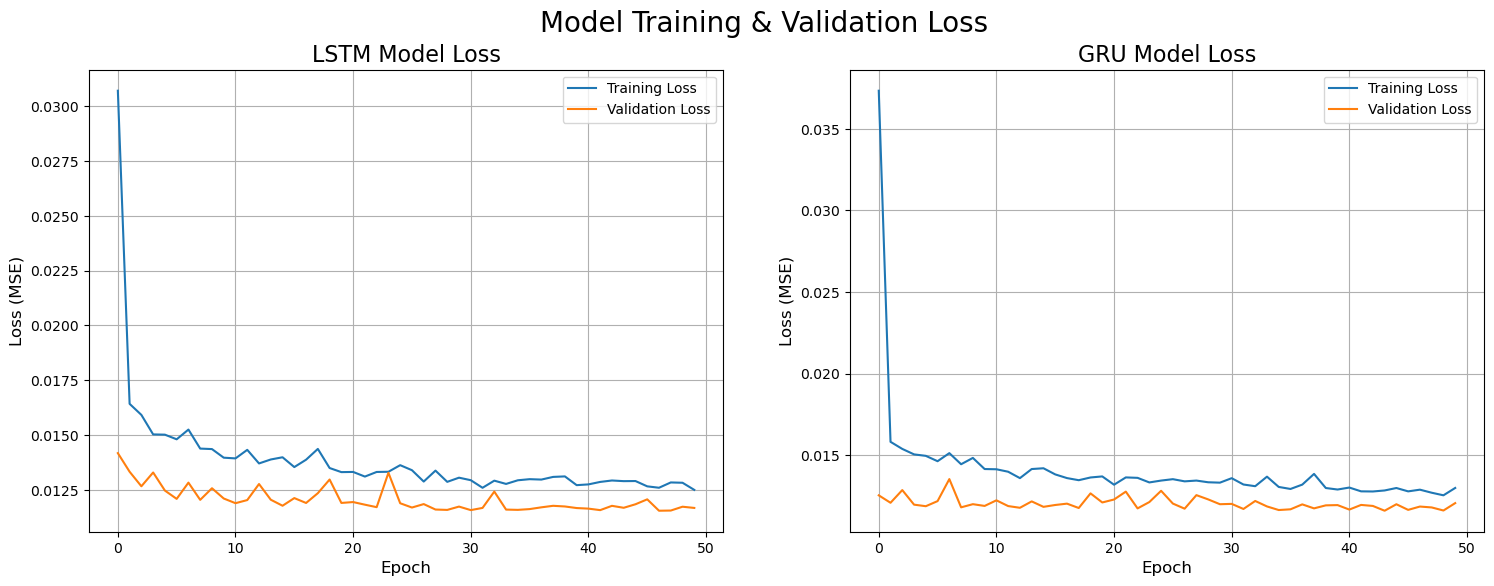

In [12]:
# Create subplots for loss visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Model Training & Validation Loss', fontsize=20)

# Plot 1: LSTM Loss
ax1.plot(history_LSTM.history['loss'], label='Training Loss')
ax1.plot(history_LSTM.history['val_loss'], label='Validation Loss')
ax1.set_title('LSTM Model Loss', fontsize=16)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss (MSE)', fontsize=12)
ax1.legend()
ax1.grid(True)

# Plot 2: GRU Loss
ax2.plot(history_GRU.history['loss'], label='Training Loss')
ax2.plot(history_GRU.history['val_loss'], label='Validation Loss')
ax2.set_title('GRU Model Loss', fontsize=16)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Loss (MSE)', fontsize=12)
ax2.legend()
ax2.grid(True)

plt.show()

In [13]:
import pickle
from sklearn.preprocessing import MinMaxScaler

# --- FIX: Fit the scaler on the correct features the model is trained on ---
# The scaler MUST be fitted on 'PremiseIndex' and 'Season_Wet' from the training data.
features_to_scale = train_df[['PremiseIndex', 'Season_Wet']]

scaler = MinMaxScaler()
scaler.fit(features_to_scale) # Fit ONLY on the training data

# Save the correctly fitted scaler to a file
with open('timeseries_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Scaler for Time Series model has been correctly created and saved to 'timeseries_scaler.pkl'")

✅ Scaler for Time Series model has been correctly created and saved to 'timeseries_scaler.pkl'


In [14]:
model_GRU.save('timeseries_model.h5')